In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
# from sklearn import decision_tree
from sklearn import metrics

In [31]:
# 読み込み→floatへ→平均補完orドロップ→intへ変換
df_test = pd.read_csv('./csv/test.csv', index_col='PassengerId', dtype='object')
df_test.Age = df_test.Age.astype(float)# Ageは、1より小さいなら小数らしいが、どうでもいいのでintにしてしまう
df_test.Age.fillna(df_test.Age.mean(), inplace=True)
df_test.Age = df_test.Age.astype(int)
# print(df_test.isnull().sum(), 'test\n')
df_train = pd.read_csv('./csv/train.csv', index_col='PassengerId', dtype='object')
df_train.Age = df_train.Age.astype(float)
df_train.dropna(subset=['Age', 'Embarked'], inplace=True)
df_train.Age = df_train.Age.astype(int)
# print(df_train.isnull().sum(), 'train\n')

# Xとyに分割
X_test = df_test
X_train = df_train.drop(columns=['Survived'])
y_train = df_train['Survived'].copy().astype(int)

# Xを結合して、前処理を行う
df_X = pd.concat([X_train, X_test])[['Pclass', 'Sex', 'Age', 'Embarked', 'SibSp', 'Parch']]# 892行目からテストデータ
# maleが1
df_X.Sex = (df_X.Sex == 'male').astype(int)
df_X.loc[:, ['Pclass', 'SibSp', 'Parch']] = df_X.loc[:, ['Pclass', 'SibSp', 'Parch']].apply(lambda x: x.astype(int))
# drop_firstしないと、ダミー列がS, Q, Cの3列になり、影響が大きすぎるため。
df_X = pd.get_dummies(df_X, drop_first=True)
# Embarked、0, 0.5, 1よりdummiesのほうが高かった。

# Standard Scaling @ Age
ss = StandardScaler()
std_age = ss.fit_transform(df_X[['Age']])
df_X.Age = std_age
# Pclassを-1,0,1にはしないほうがいい

# df_X.isnull().sum()# 欠損値の処理は完了
print(df_X.dtypes)
# print(y_train.dtypes)

# Xを分割
X_train = df_X.loc[1:891].copy()
X_test = df_X.loc[892:].copy()
train_master = pd.concat([X_train, y_train], axis=1)# グラフ書くためにyが書いてあるdfが必要だから

# 確認
display(df_X)
display(train_master)

Pclass          int64
Sex             int64
Age           float64
SibSp           int64
Parch           int64
Embarked_Q      uint8
Embarked_S      uint8
dtype: object


,Pclass,Sex,Age,SibSp,Parch,Embarked_Q,Embarked_S
PassengerId,,,,,,,
1,3,1,-0.566003,1,0,0,1
2,1,0,0.590176,1,0,0,0
3,3,0,-0.276959,0,0,0,1
4,1,0,0.373392,1,0,0,1
5,3,1,0.373392,0,0,0,1
...,...,...,...,...,...,...,...
1305,3,1,0.012086,0,0,0,1
1306,1,0,0.662437,0,0,0,0
1307,3,1,0.590176,0,0,0,1


,Pclass,Sex,Age,SibSp,Parch,Embarked_Q,Embarked_S,Survived
PassengerId,,,,,,,,
1,3,1,-0.566003,1,0,0,1,0
2,1,0,0.590176,1,0,0,0,1
3,3,0,-0.276959,0,0,0,1,1
4,1,0,0.373392,1,0,0,1,1
5,3,1,0.373392,0,0,0,1,0
...,...,...,...,...,...,...,...,...
886,3,0,0.662437,0,5,1,0,0
887,2,1,-0.204697,0,0,0,1,0
888,1,0,-0.782787,0,0,0,1,1


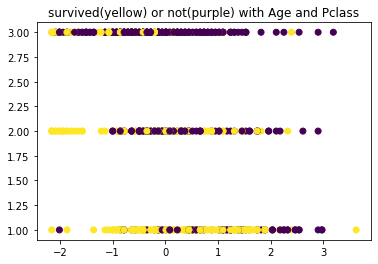

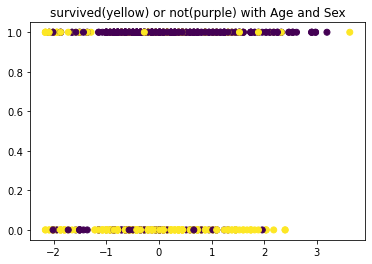

In [32]:
# 2つ特徴量を受け取り、正解ラベルを色で表現する
def make_scatter(x, y):
    plt.scatter(X_train[x], X_train[y], c=y_train)
    plt.title('survived(yellow) or not(purple) with {} and {}'.format(x, y))
    plt.show()

for x, y in [('Age', 'Pclass'), ('Age', 'Sex')]:
    # maleが1,femaleが0
    make_scatter(x, y)

# def make_barplot(column_list):# column_listにわたすと
#     for name in column_list:
#         sr = train_master.groupby(name).apply(lambda x: x.Survived.sum()/x.Survived.count())
#         plt.bar(sr.index, sr)
#         plt.title('the ratio of survivors from each {}'.format(name))
#         plt.show();

# # make_barplot(['Pclass', 'SibSp', 'Parch'])

In [33]:
lr = LogisticRegression()
# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                    intercept_scaling=1, l1_ratio=None, max_iter=100,
#                    multi_class='warn', n_jobs=None, penalty='l2',
#                    random_state=None, solver='warn', tol=0.0001, verbose=0,
#                    warm_start=False)

lr.fit(X_train, y_train)
sr_result = lr.predict(X_test)

In [34]:
df_output = pd.read_csv('./csv/gender_submission.csv')
df_output.Survived = sr_result
df_output.to_csv('./csv/titanic_output.csv', index=False)
df_output

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [35]:
# 学習データをそのまま入力したときにこのモデルでの正確率を得ることで、過学習していないかを見てみよう
sr_train_result = lr.predict(X_train)
df_train_result = pd.DataFrame(y_train).copy()
df_train_result.Survived = sr_train_result

# recall_score
metrics.recall_score(y_train, df_train_result)

0.71875

In [36]:
# accuracy_score
lr.score(X_train, y_train)

0.8047752808988764

# 正規化について@Age

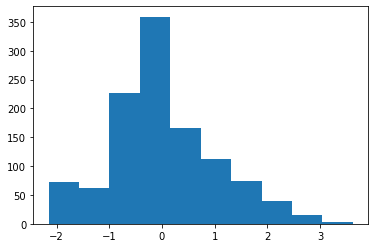

In [37]:
plt.hist(df_X.Age);

-6.759587972939006e-17 1.0


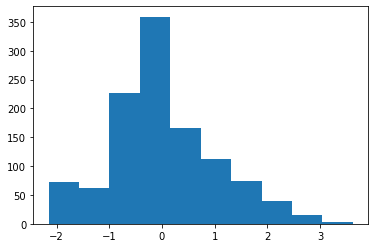

In [38]:
print(std_age.mean(), std_age.std())
plt.hist(std_age);
# 分布は変わらない。最大と最小はコントロールできない。
# 対して、minmaxscalerは最大と最小を決める。